In [ ]:
from PIL import Image
from pathlib import Path

import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.io import decode_image
from torchvision import models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
path = kagglehub.dataset_download("tongpython/cat-and-dog")
path

'/home/usr/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1'

In [ ]:
dataroot = Path(path)

In [ ]:
for child in dataroot.iterdir():
    print(child.name)
    if child.is_dir():
        for grandchild in child.iterdir():
            print(f"  {grandchild.name}")
    else:
        print(f"  {child.name}")

training_set
  training_set
test_set
  test_set


In [ ]:
train_data_dir = dataroot / "training_set" / "training_set"
test_data_dir = dataroot / "test_set" / "test_set"

In [ ]:
for child in train_data_dir.iterdir():
    print(child.name)
    if child.is_dir():
        for grandchild in child.iterdir():
            print(f"  {grandchild.name}")
            break
    else:
        print(f"  {child.name}")

print()

for child in test_data_dir.iterdir():
    print(child.name)
    if child.is_dir():
        for grandchild in child.iterdir():
            print(f"  {grandchild.name}")
            break
    else:
        print(f"  {child.name}")

dogs
  dog.1698.jpg
cats
  cat.3878.jpg

dogs
  dog.4603(1).jpg
cats
  cat.4386.jpg


In [ ]:
dog_files = sorted(list((train_data_dir / "dogs").glob("*.jpg")))
cat_files = sorted(list((train_data_dir / "cats").glob("*.jpg")))
print(f"Number of dog files: {len(dog_files)}")
print(f"Number of cat files: {len(cat_files)}")

Number of dog files: 4005
Number of cat files: 4000


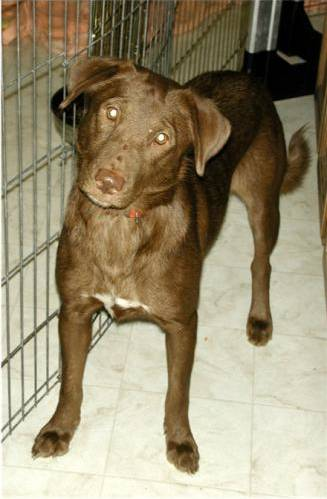

In [ ]:
Image.open(dog_files[0])

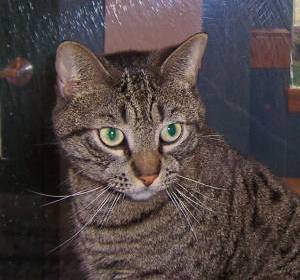

In [ ]:
Image.open(cat_files[0])

In [ ]:
class cats_dogs(Dataset):
  def __init__(self, folder, transform=None):
    cats = sorted((folder / "cats").glob("*.jpg"))
    dogs = sorted((folder / "dogs").glob("*.jpg"))
    self.fpaths = cats + dogs
    self.labels = [int(f.stem.startswith("dog")) for f in self.fpaths] # dog=1 & cat=0
    self.transform = transform

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, idx):
    label = self.labels[idx]
    image = decode_image(self.fpaths[idx])
    if self.transform:
      image = self.transform(image)
    return image, label

torch.Size([3, 280, 300]) 0


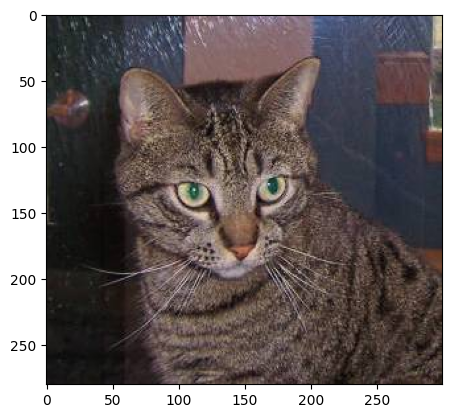

In [ ]:
train_dataset = cats_dogs(train_data_dir)
sample = train_dataset[0]
print(sample[0].shape, sample[1])
plt.imshow(sample[0].permute(1, 2, 0))
plt.show()

In [ ]:
weights = models.VGG16_Weights.DEFAULT

In [ ]:
transform = weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
means = torch.tensor(transform.mean).reshape(3, 1, 1)
stds = torch.tensor(transform.std).reshape(3, 1, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.7865399].


torch.Size([3, 224, 224]) 0


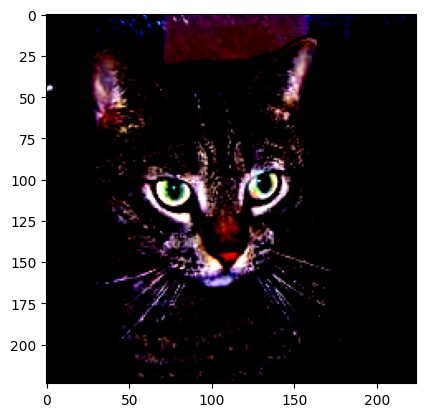

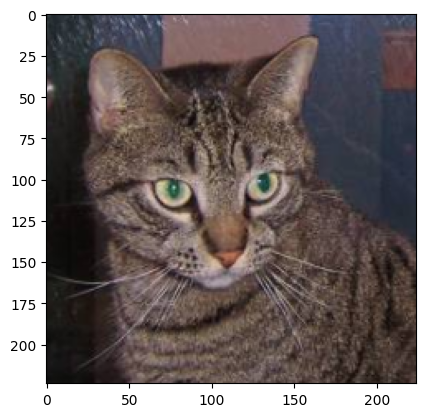

In [ ]:
train_dataset = cats_dogs(train_data_dir, transform=transform)
sample = train_dataset[0]
print(sample[0].shape, sample[1])

plt.figure()
plt.imshow(sample[0].permute(1, 2, 0))
plt.show()

plt.figure()
plt.imshow((sample[0]*stds + means).permute(1, 2, 0))
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),

            nn.LazyLinear(256),
            nn.BatchNorm1d(num_features=256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.LazyLinear(1),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
model = CNN()

In [ ]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 112, 112]         64
│    └─LeakyReLU: 2-3                    [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 32, 56, 56]           --
│    └─Conv2d: 2-5                       [1, 64, 28, 28]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 28, 28]           128
│    └─LeakyReLU: 2-7                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-8                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-9                       [1, 128, 7, 7]            73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 7, 7]            256
│    └─LeakyReLU: 2-11                   [1, 128, 7, 7]            --
│   

In [ ]:
train_dataset = cats_dogs(train_data_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
num_epochs = 5
for batch in train_dataloader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)

    print(x.dtype, x.shape)
    print(y.dtype, y.shape)
    print(y_pred.dtype, y_pred.shape)

    loss = loss_fn(y_pred, y)
    print(loss.item())
    break

torch.float32 torch.Size([32, 3, 224, 224])
torch.int64 torch.Size([32])
torch.float32 torch.Size([32, 1])


ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1]))

In [ ]:
num_epochs = 5
for batch in train_dataloader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x).squeeze()
    
    print(x.dtype, x.shape)
    print(y.dtype, y.shape)
    print(y_pred.dtype, y_pred.shape)

    loss = loss_fn(y_pred, y)
    print(loss.item())
    break

torch.float32 torch.Size([32, 3, 224, 224])
torch.int64 torch.Size([32])
torch.float32 torch.Size([32])


RuntimeError: result type Float can't be cast to the desired output type Long

In [ ]:
num_epochs = 5
for batch in train_dataloader:
    x, y = batch
    x, y = x.to(device), y.float().to(device)
    y_pred = model(x).squeeze()
    
    print(x.dtype, x.shape)
    print(y.dtype, y.shape)
    print(y_pred.dtype, y_pred.shape)

    loss = loss_fn(y_pred, y)
    print(loss.item())
    break

torch.float32 torch.Size([32, 3, 224, 224])
torch.float32 torch.Size([32])
torch.float32 torch.Size([32])
0.6199533939361572


In [ ]:
@torch.inference_mode()
def accuracy(x, y, model):
    prediction = F.sigmoid(model(x).squeeze())
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
y

tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')

In [ ]:
model(x).squeeze()

tensor([-0.4103, -0.5131,  0.1417, -0.6742, -0.3169, -0.6067,  0.0240, -0.0589,
        -0.5253, -0.5702, -0.6361,  0.2552,  1.1196,  0.0468, -0.1356,  0.4154,
        -0.6433, -0.0300, -0.7690, -0.9555, -0.2031, -0.1301,  0.1827, -0.5745,
         0.0503, -0.5856,  0.0570, -0.8033, -0.5958,  0.3117,  0.4176, -0.2458],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
F.sigmoid(model(x).squeeze())

tensor([0.2439, 0.4202, 0.5279, 0.5524, 0.4266, 0.3480, 0.3042, 0.4486, 0.5259,
        0.4875, 0.4144, 0.2954, 0.4746, 0.3916, 0.5626, 0.4780, 0.3316, 0.3492,
        0.3421, 0.3270, 0.3003, 0.4628, 0.3923, 0.3544, 0.4464, 0.5579, 0.4497,
        0.3911, 0.3481, 0.3641, 0.4514, 0.4329], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [ ]:
accuracy(x, y, model)

[False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True]

In [ ]:
np.mean(accuracy(x, y, model))

np.float64(0.6875)

In [ ]:
train_dataset = cats_dogs(train_data_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = cats_dogs(test_data_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
loss_fn = nn.BCEWithLogitsLoss()

model = CNN().to(device)
optimizer = Adam(model.parameters(), lr=1e-5)

num_epochs = 5

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_epoch_accuracies = []

    train_loader = tqdm(train_dataloader)
    train_loader.set_description(f"Train {epoch}/{num_epochs}")
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.float().to(device)
        y_pred = model(x).squeeze()

        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loader.set_postfix(loss=loss.item())
        train_loss += loss.item()

        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    train_accuracies.append(train_epoch_accuracy)
    print(f"Train loss: {train_loss:.4f} - Train accuracy: {train_epoch_accuracy:.4f}")

    with torch.inference_mode():
        model.eval()
        val_loss = 0
        val_epoch_accuracies = []

        val_loader = tqdm(val_dataloader)
        val_loader.set_description(f"Val   {epoch}/{num_epochs}")
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.float().to(device)
            y_pred = model(x).squeeze()

            loss = loss_fn(y_pred, y)

            val_loss += loss.item()

            is_correct = accuracy(x, y, model)
            val_epoch_accuracies.extend(is_correct)
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
        val_epoch_accuracy = np.mean(val_epoch_accuracies)
        val_accuracies.append(val_epoch_accuracy)
        print(f"Val loss: {val_loss:.4f} - Val accuracy: {val_epoch_accuracy:.4f}")
    print()

Train 0/5: 100%|██████████| 250/250 [00:29<00:00,  8.45it/s, loss=0.591]


Train loss: 0.6817 - Train accuracy: 0.5705


Val   0/5: 100%|██████████| 64/64 [00:04<00:00, 13.57it/s]


Val loss: 0.6558 - Val accuracy: 0.6159



Train 1/5: 100%|██████████| 250/250 [00:28<00:00,  8.81it/s, loss=0.675]


Train loss: 0.6442 - Train accuracy: 0.6316


Val   1/5: 100%|██████████| 64/64 [00:04<00:00, 14.11it/s]


Val loss: 0.6366 - Val accuracy: 0.6456



Train 2/5: 100%|██████████| 250/250 [00:28<00:00,  8.74it/s, loss=0.737]


Train loss: 0.6234 - Train accuracy: 0.6580


Val   2/5: 100%|██████████| 64/64 [00:04<00:00, 13.90it/s]


Val loss: 0.6241 - Val accuracy: 0.6639



Train 3/5: 100%|██████████| 250/250 [00:28<00:00,  8.80it/s, loss=0.586]


Train loss: 0.5998 - Train accuracy: 0.6806


Val   3/5: 100%|██████████| 64/64 [00:04<00:00, 13.48it/s]


Val loss: 0.6094 - Val accuracy: 0.6747



Train 4/5: 100%|██████████| 250/250 [00:29<00:00,  8.37it/s, loss=0.556]


Train loss: 0.5821 - Train accuracy: 0.6915


Val   4/5: 100%|██████████| 64/64 [00:04<00:00, 13.04it/s]

Val loss: 0.5988 - Val accuracy: 0.6970



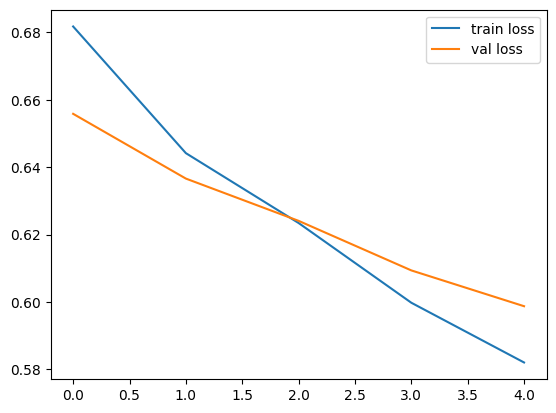

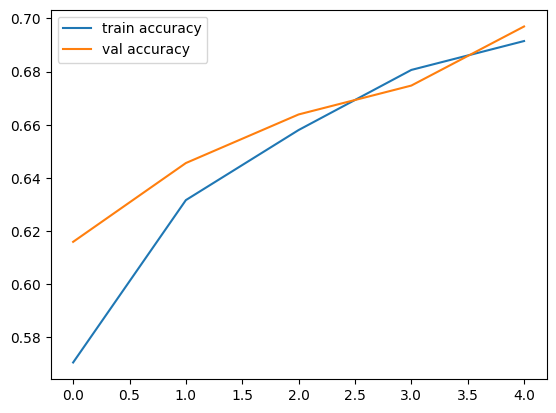

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="train accuracy")
plt.plot(val_accuracies, label="val accuracy")
plt.legend()
plt.show()